# Topic Modelling with `tfp` built-in sampling utilities

In [999]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [1000]:
from importlib import reload  

import topicflow.utils  as tp_utils
import topicflow.data   as tp_data
import topicflow.models as tp_models

tp_utils  = reload(tp_utils)
tp_data   = reload(tp_data)
tp_models = reload(tp_models)

## Settings & Data

In [1001]:
N_docs = 300
sqrt_N_vocab = 3
N_words = 50

ragged = True

N_topics = int(2*sqrt_N_vocab)
N_vocab = int(sqrt_N_vocab**2)

In [1002]:
if ragged:
    data = tp_data.squareLDDocuments(
        N_docs=N_docs, 
        sqrt_N_vocab=sqrt_N_vocab, 
        N_words_rate=N_words)

if not ragged:   
    data = tp_data.squareLDDocuments(
        N_docs=N_docs, 
        sqrt_N_vocab=sqrt_N_vocab, 
        N_words_fixed=N_words)


In [1003]:
Theta, Pi, C_DId, C_DIdK, W_DId = data.extract_params()

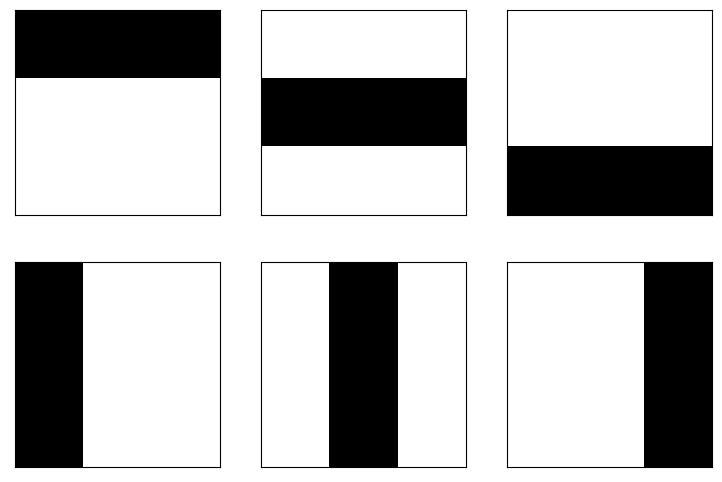

In [1004]:
_ = tp_utils.visualize_topics(Theta, N_row=2, N_col=3)

## Inference

Thx to https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability

The Joint Model is:
- $\Theta$ fixed
- $\Pi \sim \textsf{Dirichlet}(\alpha)$
- $C \vert \Pi \sim \textsf{Categorical}(\Pi)$ 
- $P(w_{di}=v \vert c_{dik}, \Theta) = \prod_k \Theta_{kv}^{c_{dik}}$, where $c_{dik}$ is one-hot encoded. This is equivalend to $W \vert C, \Theta \sim \textsf{Categorical}(\texttt{tf.gather(} \Theta, C \texttt{)} )$

The "$C$-step" can be integrated out using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).

### Testing Behavior of `tfd.Sample(tfd.MixtureSameFamily(...))`

In [1005]:
Pi_test = tf.one_hot(np.arange(0, N_topics), N_topics)
Pi_test.shape

TensorShape([6, 6])

In [1006]:
test0 = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=Pi_test
    ),
    components_distribution=tfd.Categorical(
        probs=Theta
    )
).sample(N_words)

In [1007]:
tf.transpose(test0).shape

TensorShape([6, 50])

In [1008]:
test1 = tfd.Sample(  
    tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=Pi_test
        ),
        components_distribution=tfd.Categorical(
            probs=Theta
        )
    ),
    sample_shape=(N_words)
).sample()

In [1009]:
test1.shape

TensorShape([6, 50])

Presenting documents [0 1 5 2 4 3]


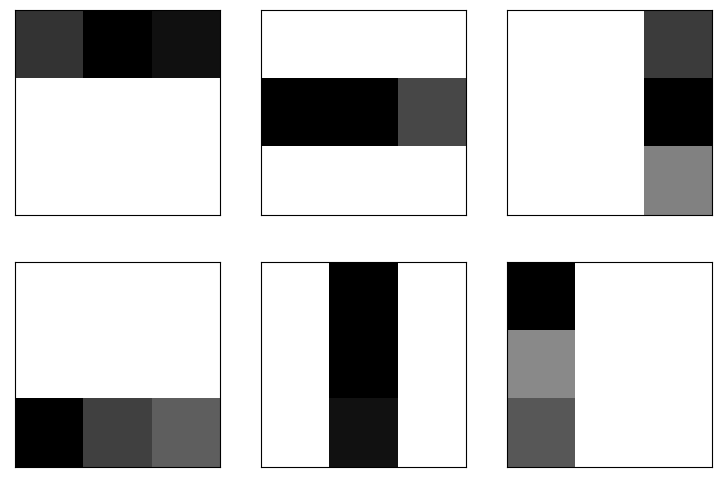

In [1010]:
_ = tp_utils.visualize_random_docs(test1, sqrt_N_vocab, 2, 3, False)

### Defining the Joint

In [1011]:
## Priors:
alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)
N_words_max = N_words


## Variable Lengths
#  There is no capability for variable document length in tensorflow probability
#  (as far as I know, 2022-11-14). Therefore I pad each document by sampling 
#  from the observed frequency of words in the document "plain"to the maximum 
#  doclength.
if ragged:
    pad_token = N_vocab + 1
    single_doclengths = W_DId.nested_row_lengths()[0].numpy()
    N_words_max = tf.reduce_max(single_doclengths)
    N_words_mean = tf.cast(tf.reduce_mean(single_doclengths), tf.float32)

    W_DId_ragged = W_DId.to_tensor(N_vocab+1).numpy()
    W_DId = []

    def pad_single_doc(doc, length, N_words_max=N_words_max):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(W_DId_ragged, single_doclengths):
        W_DId.append(pad_single_doc(doc, length))
    
    W_DId = tf.constant(W_DId, dtype=tf.int32)
        
        
## Joint
joint = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
        W     = lambda Pi, Theta: tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(
                    probs=Pi
                ),
                components_distribution=tfd.Categorical(
                    probs=Theta
                )
            ),
            sample_shape=(N_words_max)
        )
    ),
    batch_ndims=0,
    use_vectorized_map=True
)



In [1012]:
joint.sample()['W'].shape

TensorShape([300, 74])

In [1013]:
## Testing
joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta)

<tf.Tensor: shape=(), dtype=float32, numpy=-43818.113>

Presenting documents [195 273  19 107  81  94   4 159 257 188]


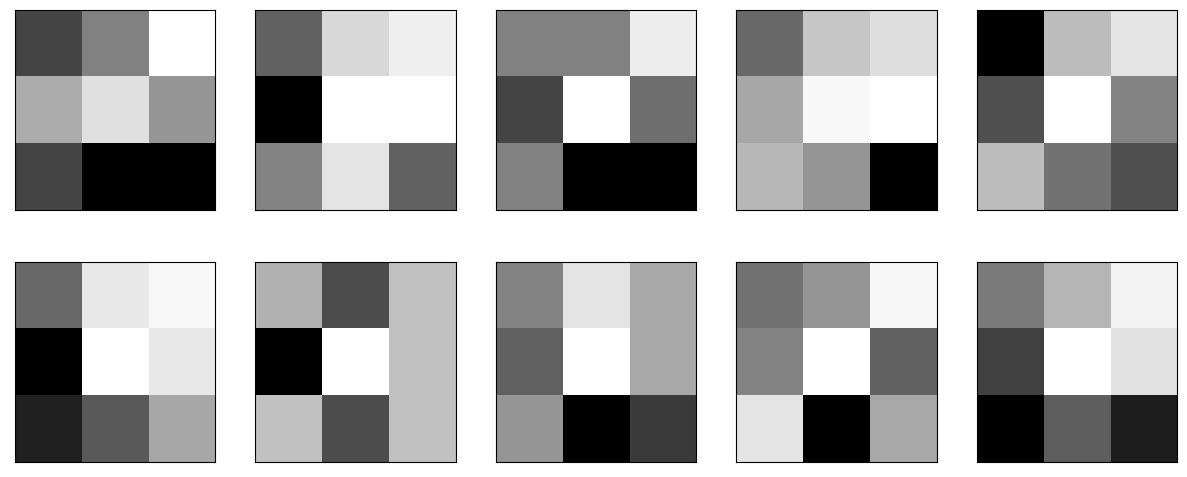

In [1014]:
## Visualize draw from the prior-joint
_ = tp_utils.visualize_random_docs(joint.sample()['W'], sqrt_V=sqrt_N_vocab)

### Defining the unnormalized Posterior by introducing the Data:

In [1015]:
def unnormalized_posterior(Pi, Theta):
    return joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta) # Incorporate data with W_DId

### HMC-Chain

In [1016]:
## tf-magic
tf.config.experimental.enable_tensor_float_32_execution(False)

In [1017]:
## Constraining the Dirichlet-Samples to discrete probability vectors
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered()
]

In [1018]:
# Create an HMC TransitionKernel
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior,
            step_size=0.065,
            num_leapfrog_steps=5
        ),
    bijector=unconstraining_bijectors
    ),
    num_adaptation_steps=400
)

In [1019]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

In [1020]:
initial_state = [
    tf.ones_like(Pi,    dtype=tf.float32), 
    tf.ones_like(Theta, dtype=tf.float32)
]
samples, is_accepted = run_chain(initial_state)

In [1021]:
print("Acceptance rate:", tf.reduce_sum(tf.cast(is_accepted, dtype=tf.int16)/is_accepted.shape[0]).numpy())

Acceptance rate: 0.559


In [1022]:
Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)

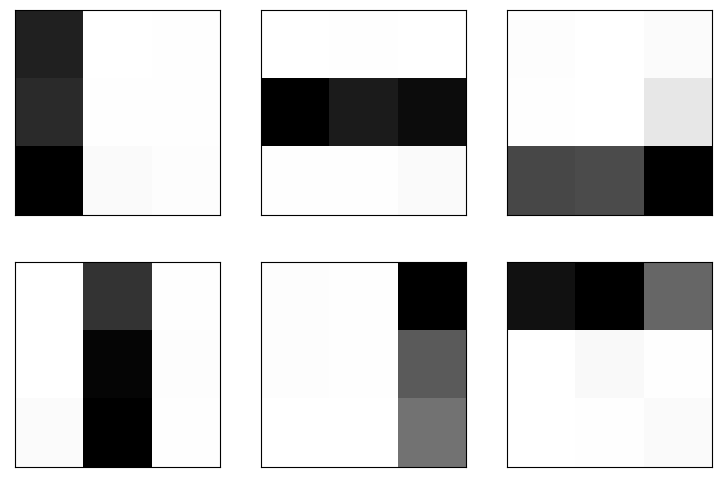

In [1023]:
_ = tp_utils.visualize_topics(Theta_fit, N_row=2, N_col=3)

In [1024]:
initial_state = [
    Pi_fit, 
    Theta_fit
]
samples, is_accepted = run_chain(initial_state)

In [1025]:
Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)

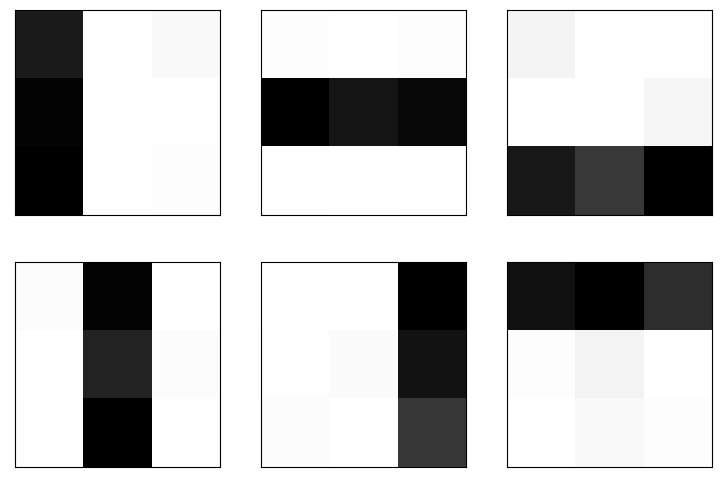

In [1026]:
_ = tp_utils.visualize_topics(samples[1][-1, :], N_row=2, N_col=3)